Below I present a solution leading to a score of 6065 (5th place at the time of writing this). Additionally, I tell a brief history of attempted cost-lowering strategies.

author: Witold Jarnicki

email: witek@beit.tech

## 1. Structure of the document
Table 1 presents a list of ideas introduced, along with their (approximate) score and the number of the section describing the details. All my solutions use a common approach described in Section 2.
It is recommended that the reader familiarize themselves with that section as a prerequisite.
$\newcommand{\ket}[1]{\left|#1\right>}\DeclareMathOperator{\RCCX}{RCCX}$

Each section is followed by a pure-code cell containing the implementation of the ideas from the section. To save space, I am not including full solutions, but just code snippets containing the most important bits.

Additionally, Section 9 contains the full final solution, ready to be run and graded.

Last but not least, Section 10 contains auxiliary code snippets used during development.

<center>

| Idea name                   | Score       | Section   |
|-----------------------------|------------:|----------:|
|CNF proof of concept         | ~ 3 000 000 |         3 |
|Board symmetry (later banned)| ~   170 000 |         4 |
|Matching                     | ~    20 000 |         5 |
|Weighted phase oracle        | ~     7 500 |         6 |
|Micro-optimizations          | ~     6 500 |         7 |
|Smart QRAM loading           |       6 065 |         8 |

*Table 1. Ideas introduced into my solution throughout the contest.*

</center>

In [9]:
#### One-time setup after Kernel reset.
# Lower limit to 5000.
!pip install -I git+https://github.com/qiskit-community/IBMQuantumChallenge2020-Grader.git

problem_set = \
    [
    [['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
    [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
    [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
    [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
    [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']],
    [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
    [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
    [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
    [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']],
]

  Cloning https://github.com/qiskit-community/IBMQuantumChallenge2020-Grader.git to /tmp/pip-req-build-wmbh0ehw
  Using cached numpy-1.19.4-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
Processing /home/jovyan/.cache/pip/wheels/bc/b7/b0/9099f1685d1bed7d4f5a7ee189ab41d3fb71ae44d71ac05994/qiskit-0.23.1-py3-none-any.whl
  Using cached requests-2.25.0-py2.py3-none-any.whl (61 kB)
  Using cached qiskit_aqua-0.8.1-py3-none-any.whl (2.1 MB)
  Using cached qiskit_ignis-0.5.1-py3-none-any.whl (204 kB)
  Using cached qiskit_terra-0.16.1-cp37-cp37m-manylinux2010_x86_64.whl (8.5 MB)
  Using cached qiskit_ibmq_provider-0.11.1-py3-none-any.whl (195 kB)
  Using cached qiskit_aer-0.7.1-cp37-cp37m-manylinux2010_x86_64.whl (17.5 MB)
  Using cached urllib3-1.26.2-py2.py3-none-any.whl (136 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached certifi-2020.12.5-py2.py3-none-any.whl (147 kB)
     |████████████████████████████████|

## 2. The common computation model and notation

I made a very early decision to use a classical Boolean-logic oracle for each board. Before that I made some attempts 
at building a "true quantum" approach involving considering all shot possibilities, but I was always
running out of qubits, so ultimately I gave up on it.

Each of my solutions follows the diagram on Figure 1.

The parts $A$ (address ancilla preparation $\ket0\ket a\longmapsto\ket{f(a)}\ket a$), $O$ (phase
oracle), and $D$ (the diffusion operator) must be independent of the input data.

The part $Q$ (loading QRAM) can depend on data and must adhere to the rule
$\ket{f(a)}\ket{a}\ket0\ket0\longmapsto\ket{f(a)}\ket{a}\ket{g(a)}\ket0$, where $g(a)$ is the
unprocessed data of board $a$.

I have bent the last rule a little in one of my intermediate solutions, but I requested that the organizers withdraw it, once I learnt it was forbidden. For the final solution I
have $s=16$ and $g(a)$ is the exact bitmap of zeroes and ones, as read row-by-row from board $a$.

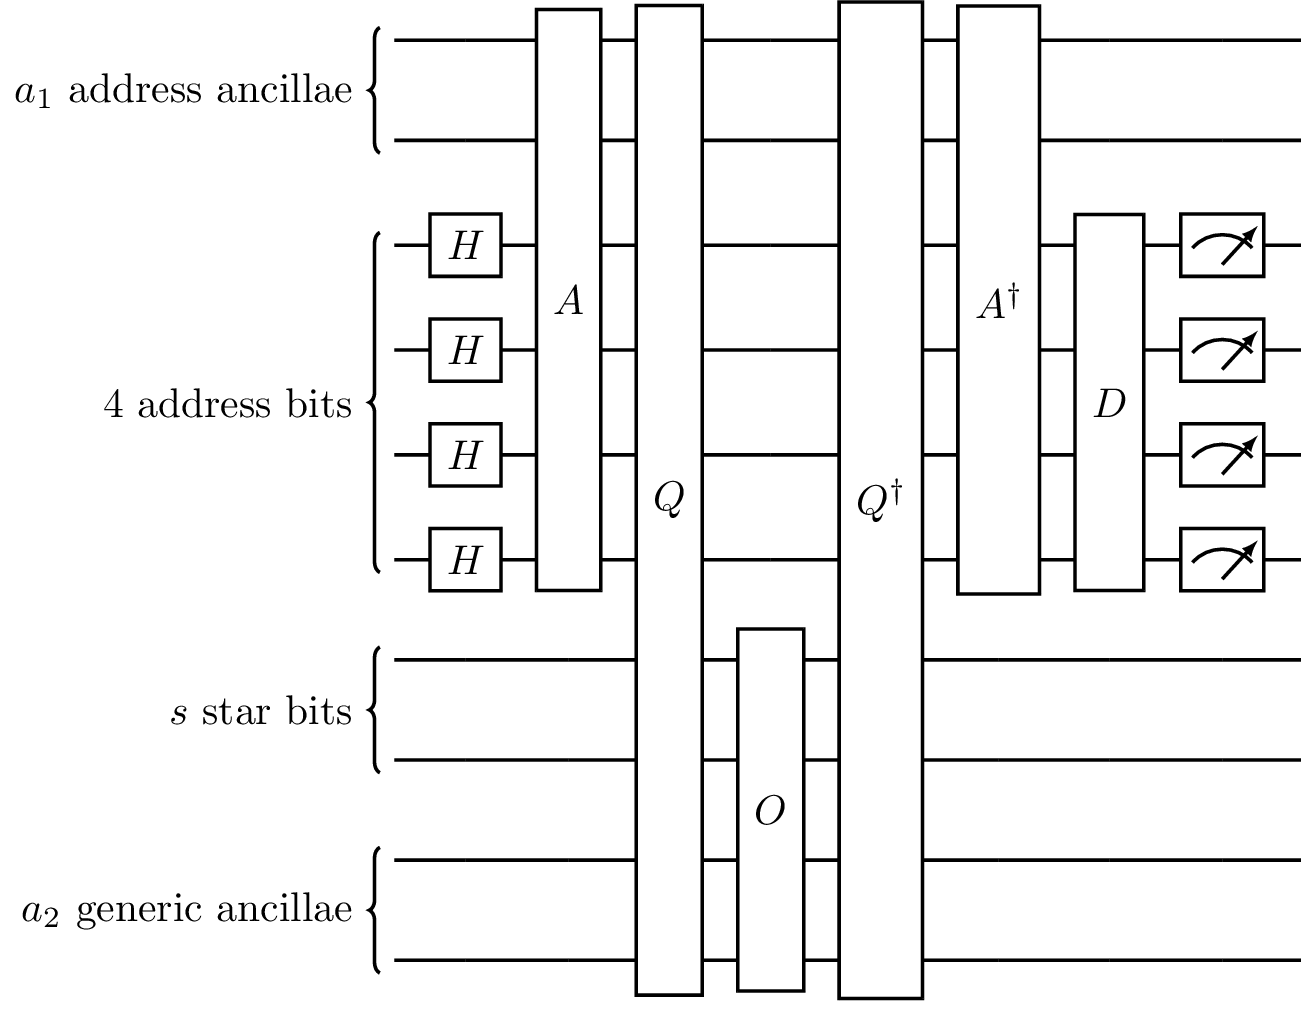
    
*Figure 1. A circuit template used by all my solutions.*


In [ ]:
def address_xor(qc, address, i):
    for bit in range(4):
        if i & (1 << bit):
            qc.x(address[bit])

# Enables a particular star on board #15.
def star_xor(qc, address, star, ancilla):
    qc.mct(address, star, ancilla)

# A very early version of the QRAM loader. It did not use Gray-code chains and had an MCT for every single
# star!
def QRAM(qc, address, stars, ancilla, problem_set):
    for i in range(16):
        # Negate address bits, so that board #15 corresponds to board #i.
        address_xor(qc, address, 15 - i)
        star_numbers = [4 * int(r) + int(c) for r, c in problem_set[i]]
        for star_number in star_numbers:
            star_xor(qc, address, stars[star_number], ancilla)
        # Negate the address bits back to their original values.
        address_xor(qc, address, 15 - i)
        
# Initially, just copied from one of the previous weeks.
def diffusion(qc, database, auxiliary):
    qc.h(database[:])
    qc.x(database[:])
    qc.h(database[3])
    qc.mct(database[0:3], database[3], auxiliary[:], mode='basic')
    qc.h(database[3])
    qc.x(database[:])
    qc.h(database[:])

# A very early version of the common main function. Observe that the A subcircuit is missing, as it was not
# introduced until Section 7.
def week3_ans_func(problem_set):
    ### Step 0. Circuit setup.
    address = QuantumRegister(4) # Problem set index
    stars = QuantumRegister(16)  # Star bitmap.
    ancilla = QuantumRegister(8) # Ancilla.
    c1 = ClassicalRegister(4)    # Answer
    c2 = ClassicalRegister(16)   # Debug: board;
    c3 = ClassicalRegister(8)    # Debug: ancilla.
    # A version of the circuit that allows reading out ancilla qubits. Useful for checking if everything
    # got properly uncomputed.
    # qc = QuantumCircuit(address, stars, ancilla, c1, c2, c3)
    qc = QuantumCircuit(address, stars, ancilla, c1)
    
    ### Step 1. Start with equal superposition of boards;
    qc.h(address)
    
    ### Step 2. 1-iteration Grover, as required by the problem statement.
    for i in range(1):
        ### Step 2a. Load data into QRAM.
        QRAM(qc, address, stars, ancilla, problem_set)
        ### Step 2b. Apply Oracle.
        oracle(qc, stars, ancilla)
        ### Step 2c. Unload data from QRAM to enable interference.
        QRAM(qc, address, stars, ancilla, problem_set)
        ### Step 2d. Apply the mixing operator.
        diffusion(qc, address, ancilla)
        
    ### Step 3. Read out the answer.
    qc.measure(address, c1)
    # qc.measure(stars, c2)
    # qc.measure(ancilla, c3)
    
    ### Step 4. Work around the endianness bug, if necessary.
    qc = qc.reverse_bits()
    
    return qc

## 3. CNF proof of concept

The idea behind this solution is that being an unsolvable board can be expressed by brute
force as a conjuction of 56 (the number of ways of aligning the shots) clauses, each
consisting of an alternative of (4 or 6) qubits corresponding to the fields not covered by a
particular shot combination.

Brief description of the circuit:

1. $a_1=0$, $s=16$, $a_2=8$.
2. $A$ does nothing.
3. $Q$ is a brute-force sequential data loader.
3. $O$ computes the CNF clauses ancilla-less and uses the ancillae to store the intermediate
   conjunctions. Data aggregation is performed by ancilla-less CCCCX. Finally, we flip the
   phase on the formula result and uncompute everything.
4. $D$ is the standard Grover diffusion operator.

In [ ]:
# List all the possible sets of fields uncovered by 3 laser shots.
CLAUSES = []
for i in range(4):
    # One row missed.
    CLAUSES.append([4 * i + 0, 4 * i + 1, 4 * i + 2, 4 * i + 3])
    # One column missed.
    CLAUSES.append([4 * 0 + i, 4 * 1 + i, 4 * 2 + i, 4 * 3 + i])
    # A convoluted loop that finds all the 2x3 and 3x2 areas (choise of row and columns arbitrary).
    for j2 in range(4):
        for j1 in range(j2):
            clause_h = []
            clause_v = []
            for ii in range(4):
                if ii != i:
                    clause_h.append(4 * j1 + ii)
                    clause_h.append(4 * j2 + ii)
                    clause_v.append(4 * ii + j1)
                    clause_v.append(4 * ii + j2)
            CLAUSES.append(clause_h)
            CLAUSES.append(clause_v)

# The maximum no-ancilla MCT we are willing to use.
MAX_MCT=4

# A simple dynamic-programming loop that determines how big a CNF can be handled with a particular
# number of ancilla bits available. This assumes that every clause is computed ancilla-less.
CAPACITY = [0, 1]
while len(CAPACITY) < 10:
    cnt = 0
    for i in range(1, MAX_MCT + 1):
        if len(CAPACITY) - i >= 0:
            cnt += CAPACITY[-i]
    CAPACITY.append(cnt)

# This was supposed to use ancilla, if available, but I did not know how to use Qiskit at that time
# (notice the missing mode="basic").
def compute_clause(qc, clause, stars, target, ancilla):
    for star in clause:
        qc.x(stars[star])
    qc.mct([stars[cl] for cl in clause], target, ancilla)
    qc.x(target)
    for star in clause:
        qc.x(stars[star])

# A recursive function that splits a given CNF computation job into subjobs.
def cnf_x(qc, clauses, stars, target, ancilla):
    assert(len(clauses) <= CAPACITY[len(ancilla) + 1])
    assert(len(clauses) > 0)
    if len(clauses) == 1:
        compute_clause(qc, clauses[0], stars, target, ancilla)
        return
    assert(len(ancilla) >= 2)
    child_count = min(len(ancilla), MAX_MCT, len(clauses))
    child_offset = 0
    child_offsets = [child_offset]
    for child_index in range(child_count):
        child_offset = min(
            child_offset + CAPACITY[len(ancilla) - child_index],
            len(clauses) - child_count + child_index + 1)
        child_offsets.append(child_offset)
    for child_index in range(child_count):
        cnf_x(qc,
              clauses[child_offsets[child_index]:child_offsets[child_index + 1]],
              stars, ancilla[child_index], ancilla[child_index + 1:])
    if target is None:
        qc.h(ancilla[child_count - 1])
        qc.mct(ancilla[:child_count - 1], ancilla[child_count - 1], ancilla[child_count:])
        qc.h(ancilla[child_count - 1])
    else:
        qc.mct(ancilla[:child_count], target, ancilla[child_count:])
    for child_index in range(child_count - 1, -1, -1):
        cnf_x(qc,
              clauses[child_offsets[child_index]:child_offsets[child_index + 1]],
              stars, ancilla[child_index], ancilla[child_index + 1:])

def oracle(qc, stars, ancilla):
    cnf_x(qc, CLAUSES, stars, None, ancilla)

## 4. Exploiting board symmetry

One can prove that for each $4\times4$ board with $6$ chosen elements there exists a board
isomorphism (consisting of permuting columns, permuting rows, and optionally flipping about the
diagonal) such that $3$ particular fields always end-up chosen (numbers $9$, $14$, and $15$, to be
exact). The solution preprocesses the boards so that that is the case. We can then significantly
reduce the number of clauses, as some are guaranteed to evaluate to true.

The circuit is pretty much identical to the one from Section 3, except that it uses $s=13$,
has fewer clauses to compute, and uses the regained qubits as ancilla to speed up some of the
ancilla-less operations.

In [ ]:
# Symmetry: clauses containing 9, 14, or 15 are automatically satisfied.
CLAUSES = [clause for clause in CLAUSES if 9 not in clause]
CLAUSES = [clause for clause in CLAUSES if 14 not in clause]
CLAUSES = [clause for clause in CLAUSES if 15 not in clause]

# Very ugly symmetry finder. Slimy but satisfying ;)
def FindSymmetryUsed(used):
    for r_9 in range(4):
        for c_9 in range(4):
            if (r_9, c_9) in used:
                for r_14_15 in range(4):
                    if r_14_15 != r_9:
                        for c_14 in range(4):
                            if (r_14_15, c_14) in used:
                                if c_14 != c_9:
                                    for c_15 in range(4):
                                        if (r_14_15, c_15) in used:
                                            if c_15 not in [c_9, c_14]:
                                                row_dict = {}
                                                row_dict[r_9] = 2
                                                row_dict[r_14_15] = 3
                                                fill = 1
                                                for i in range(4):
                                                    if i not in row_dict:
                                                        row_dict[i] = fill
                                                        fill -= 1
                                                col_dict = {}
                                                col_dict[c_9] = 1
                                                col_dict[c_14] = 2
                                                col_dict[c_15] = 3
                                                for i in range(4):
                                                    if i not in col_dict:
                                                        col_dict[i] = 0
                                                return row_dict, col_dict

# One can easily prove that there exists an isomorphism of the grid (rearrangement of rows and columns,
# plus potential diagonal flip) such that fields #9, #14, and #15 are marked. We use brute-force search
# here for code simplicity.
def FindSymmetrySet(problem_set):
    used = set()
    for r, c in problem_set:
        used.add((int(r), int(c)))
    ret = FindSymmetryUsed(used)
    if ret is not None:
        return False, ret[0], ret[1]
    used = set()
    for r, c in problem_set:
        used.add((int(c), int(r)))
    ret = FindSymmetryUsed(used)
    assert(ret is not None)
    return True, ret[0], ret[1]
                               
def QRAM(qc, address, stars, ancilla, problem_set):
    for i in range(16):
        address_xor(qc, address, 15 - i)
        # Applying symmetry: make each data set contain 9, 14, and 15 (permuting rows or columns doesn't
        # change anything).
        diagonal, row_dict, col_dict = FindSymmetrySet(problem_set[i])
        star_numbers = []
        for r, c in problem_set[i]:
            if diagonal:
                star_numbers.append(4 * row_dict[int(c)] + col_dict[int(r)])
            else:
                star_numbers.append(4 * row_dict[int(r)] + col_dict[int(c)])
        print(star_numbers)
        for star_number in star_numbers:
            if star_number not in [9, 14, 15]:
                star_xor(qc, address, stars[star_number], ancilla)
        address_xor(qc, address, 15 - i)

## 5. Perfect matching

At some moment it occurred to me that one can greatly simplify the formula involved.
One can observe that a board is unsolvable iff there exists a permutation $\sigma\in S_4$ such that
there are stars at all the fields $(j,\sigma(j))$, $j=1,\dots,4$.

This means that we can go from $56$ clauses of $4$–$6$ qubits down to $24$ clauses of $4$
qubits and still stay within the new rules that disallow reshaping the board. Additionally,
for a chosen subset $C$ of columns $\{1,2,3,4\}$ we can efficiently compute in one pass the
value of $B_C$ defined as whether the board is certified unsolvable by one of the
permutations from $\{\sigma\in S_4:\sigma(1),\sigma(2)\in C\not\ni\sigma(3),\sigma(4)\}$.

Brief description of the circuit:

1. $a_1=0$, $S=16$, $a_2=8$.
2. $A$ does nothing.
3. $Q$ is a standard Gray-code data loader.
4. $O$ flips the phase on the alternative of efficiently-computed values of $B_C$,
   taken over the six two-element subsets of $\{1,2,3,4\}$. The exact circuit is shown
   of Figure 2.
5. $D$ is the standard Grover diffusion operator.

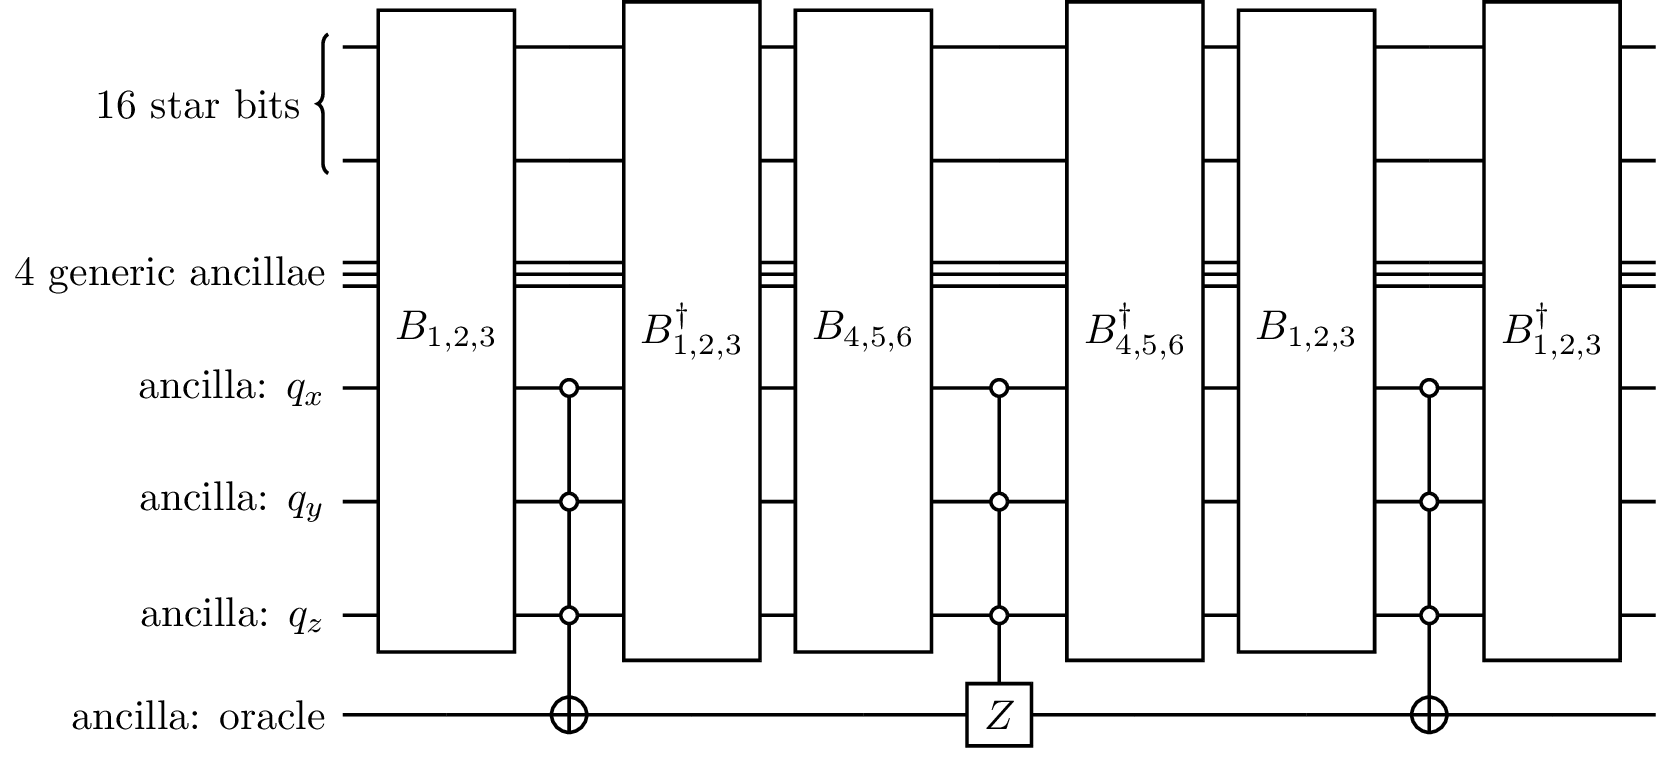

*Figure 2. The circuit that flips phase on the alternative of $\{B_{C_1},\dots,B_{C_6}\}$. The
part $B_{a,b,c}=B_{a,b,c}^\dagger$ computes $B_{C_a}$, $B_{C_b}$, and $B_{C_c}$, putting the result in $q_x$,
$q_y$, and $q_z$, respectively.*


In [ ]:
# The first solution that uses Gray-code chain with a dedicated enabler qubit.
GRAY_BITS = [0, 1, 0, 2, 0, 1, 0, 3, 0, 1, 0, 2, 0, 1, 0]
current_address = 15

def LoadBoard(board, qc, star, enabler):
    for x, y in board:
        qc.cx(enabler, star[4 * int(x) + int(y)])

def LoadQRAM(problem_set, qc, address, star, ancilla):
    FixCurrentAddress(qc, address, ancilla)
    LoadBoard(problem_set[current_address], qc, star, ancilla[7])
    for bit in GRAY_BITS:
        SwitchCurrentAddress(bit, qc, address, ancilla)
        LoadBoard(problem_set[current_address], qc, star, ancilla[7])
    UnfixCurrentAddress(qc, address, ancilla)

# As I was not able to find an earlier version, the code below already contains some minor optimizations
# (using rccx instead of ccx, manual gate synthesis by optional named arguments). Feel free to ignore them
# for now, as most of the code will be rewritten anyway.

def ComputeDiag(rows, cols, qc, star, diag):
    rccx(qc, star[4 * rows[0] + cols[0]], star[4 * rows[1] + cols[1]], diag)

def ComputeBox(rows, cols, qc, star, matching, diags, reverse=False, edge=False):
    if not edge or not reverse:
        ComputeDiag(rows, cols      , qc, star, diags[0])
        ComputeDiag(rows, cols[::-1], qc, star, diags[1])
        qc.x(diags)
    rccx(qc, diags[0], diags[1], matching)
    if not edge or reverse:
        qc.x(diags)
        ComputeDiag(rows, cols[::-1], qc, star, diags[1])
        ComputeDiag(rows, cols      , qc, star, diags[0])
        
def ComputePerms(col_12, col_34, qc, star, matchings, boxes, diags, reverse=False, edge=False):
    ComputeBox([0, 1], col_12, qc, star, boxes[0], diags, reverse=reverse, edge=(edge and reverse))
    ComputeBox([2, 3], col_34, qc, star, boxes[1], diags, reverse=reverse)
    qc.x(boxes)
    rccx(qc, boxes[0], boxes[1], matchings)
    qc.x(boxes)
    ComputeBox([2, 3], col_34, qc, star, boxes[1], diags, reverse=reverse)
    ComputeBox([0, 1], col_12, qc, star, boxes[0], diags, reverse=reverse, edge=(edge and not reverse))

def week3_ans_func(problem_set):
    address = QuantumRegister(4)
    star = QuantumRegister(16)
    three_perms = QuantumRegister(1)
    perms = QuantumRegister(3)
    boxes = QuantumRegister(2)
    diags = QuantumRegister(2)
    
    c_address = ClassicalRegister(4)
    c_perms = ClassicalRegister(3)
    c_boxes = ClassicalRegister(2)

    qc = QuantumCircuit(
        address, star, three_perms, perms, boxes, diags, c_address,
        # c_perms, c_boxes,
        )
    
    qc.h(address)

    for i in range(1):
        LoadQRAM(problem_set, qc, address, star, three_perms[:] + perms[:] + boxes[:] + diags[:])

        ComputePerms([0, 1], [2, 3], qc, star, perms[0], boxes, diags)
        ComputePerms([0, 2], [1, 3], qc, star, perms[1], boxes, diags)
        ComputePerms([0, 3], [1, 2], qc, star, perms[2], boxes, diags, edge=True)
        qc.x(perms)
        rccx(qc, perms[0], perms[1], boxes[0])
        rccx(qc, perms[2], boxes[0], three_perms)
        rccx(qc, perms[0], perms[1], boxes[0])
        qc.x(perms)
        ComputePerms([0, 3], [1, 2], qc, star, perms[2], boxes, diags, reverse=True, edge=True)
        ComputePerms([0, 2], [1, 3], qc, star, perms[1], boxes, diags, reverse=True)
        ComputePerms([0, 1], [2, 3], qc, star, perms[0], boxes, diags, reverse=True)
        
        ComputePerms([1, 2], [0, 3], qc, star, perms[0], boxes, diags)
        ComputePerms([1, 3], [0, 2], qc, star, perms[1], boxes, diags)
        ComputePerms([2, 3], [0, 1], qc, star, perms[2], boxes, diags, edge=True)

        qc.x(perms)
        rccx(qc, perms[0], perms[1], boxes[0])
        rccx(qc, perms[2], boxes[0], boxes[1])
        qc.cz(boxes[1], three_perms)
        rccx(qc, perms[2], boxes[0], boxes[1])
        rccx(qc, perms[0], perms[1], boxes[0])
        qc.x(perms)
        
        ComputePerms([2, 3], [0, 1], qc, star, perms[2], boxes, diags, reverse=True, edge=True)
        ComputePerms([1, 3], [0, 2], qc, star, perms[1], boxes, diags, reverse=True)
        ComputePerms([1, 2], [0, 3], qc, star, perms[0], boxes, diags, reverse=True)

        ComputePerms([0, 1], [2, 3], qc, star, perms[0], boxes, diags)
        ComputePerms([0, 2], [1, 3], qc, star, perms[1], boxes, diags)
        ComputePerms([0, 3], [1, 2], qc, star, perms[2], boxes, diags, edge=True)
        qc.x(perms)
        rccx(qc, perms[0], perms[1], boxes[0])
        rccx(qc, perms[2], boxes[0], three_perms)
        rccx(qc, perms[0], perms[1], boxes[0])
        qc.x(perms)
        ComputePerms([0, 3], [1, 2], qc, star, perms[2], boxes, diags, reverse=True, edge=True)
        ComputePerms([0, 2], [1, 3], qc, star, perms[1], boxes, diags, reverse=True)
        ComputePerms([0, 1], [2, 3], qc, star, perms[0], boxes, diags, reverse=True)
        
        LoadQRAM(problem_set, qc, address, star, three_perms[:] + perms[:] + boxes[:] + diags[:])
        Diffusion(qc, address, star)

    qc.measure(address, c_address)
    # qc.measure(perms, c_perms)
    # qc.measure(boxes, c_boxes)

    qc = qc.reverse_bits()  
    return qc

## 6. Weighted phase oracle

Observe that a diffusion operator amplifies the amplitude of the marked element not only
when its phase is completely flipped, but in fact in any case where its phase is somehow
changed. Naturally, the effect is much stronger as the phase approaches a complete flip.

We can take advantage of that and significantly simplify the circuit from Section 5.
As at most two out of $B_C$s evaluate to true, we can change the phase by $2\pi/3$ for all
the boards certified unsolvable by particular $B_C$. The solvable boards will stay in-phase,
while the unsolvable one will be shifted by either $2\pi/3$ or $4\pi/3$ — in both cases
sufficiently close to a complete flip for the amplitude to get amplified.
Figure 3 shows the structure of a circuit $P_C$ performing a single phase shift.

We now replace the oracle by consecutive calls to $P_C$ for all six values of $C$.

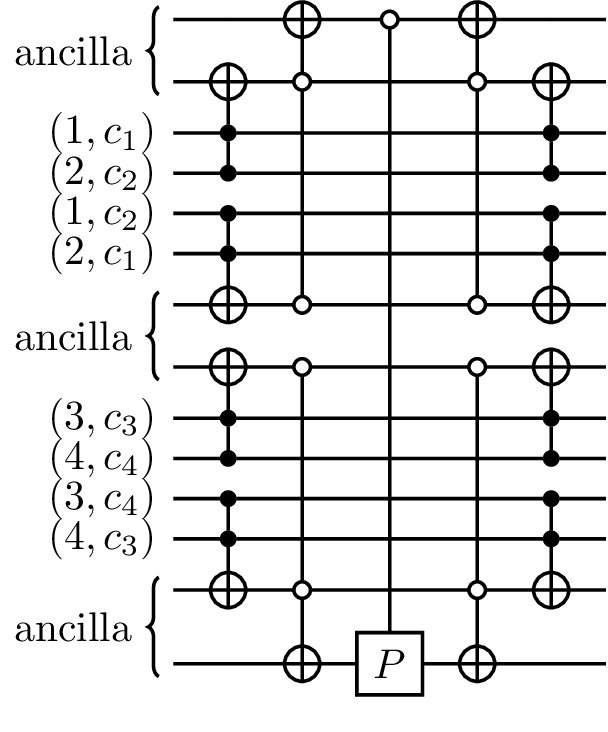

*Figure 3. The circuit $P_C$ performing the $B_C$-controlled phase shift $P$ for a column subset
$C=\{c_1,c_2\}$. We denote the elements of $\{1,2,3,4\}\setminus C$ by $c_3$ and $c_4$.*


In [ ]:
def CollectPerms(col_12, col_34, qc, star, ancilla):
    rccx(qc, star[4 * 0 + col_12[0]], star[4 * 1 + col_12[1]], ancilla[0])
    rccx(qc, star[4 * 0 + col_12[1]], star[4 * 1 + col_12[0]], ancilla[1])
    rccx(qc, star[4 * 2 + col_34[0]], star[4 * 3 + col_34[1]], ancilla[2])
    rccx(qc, star[4 * 2 + col_34[1]], star[4 * 3 + col_34[0]], ancilla[3])
    qc.x(ancilla[0:4])
    rccx(qc, ancilla[0], ancilla[1], ancilla[4])
    rccx(qc, ancilla[2], ancilla[3], ancilla[5])
    qc.x(ancilla[4:6])
    qc.cx(ancilla[4], ancilla[6])

    # Closest to -1 both for 1 and 2 applications.
    qc.cp(2 * pi / 3, ancilla[5], ancilla[6])

    qc.cx(ancilla[4], ancilla[6])
    qc.x(ancilla[4:6])
    rccx(qc, ancilla[2], ancilla[3], ancilla[5])
    rccx(qc, ancilla[0], ancilla[1], ancilla[4])
    qc.x(ancilla[0:4])
    rccx(qc, star[4 * 2 + col_34[1]], star[4 * 3 + col_34[0]], ancilla[3])
    rccx(qc, star[4 * 2 + col_34[0]], star[4 * 3 + col_34[1]], ancilla[2])
    rccx(qc, star[4 * 0 + col_12[1]], star[4 * 1 + col_12[0]], ancilla[1])
    rccx(qc, star[4 * 0 + col_12[0]], star[4 * 1 + col_12[1]], ancilla[0])

def week3_ans_func(problem_set):
    address = QuantumRegister(4)
    star = QuantumRegister(16)
    ancilla = QuantumRegister(8)
    
    c_address = ClassicalRegister(4)

    qc = QuantumCircuit(address, star, ancilla, c_address)
    
    qc.h(address)

    for i in range(1):
        LoadQRAM(problem_set, qc, address, star, ancilla)

        CollectPerms([0, 1], [2, 3], qc, star, ancilla)
        CollectPerms([0, 2], [1, 3], qc, star, ancilla)
        CollectPerms([0, 3], [1, 2], qc, star, ancilla)
        CollectPerms([1, 2], [0, 3], qc, star, ancilla)
        CollectPerms([1, 3], [0, 2], qc, star, ancilla)
        CollectPerms([2, 3], [0, 1], qc, star, ancilla)
        
        LoadQRAM(problem_set, qc, address, star, ancilla)
        Diffusion(qc, address, star)

    qc.measure(address, c_address)

    qc = qc.reverse_bits()  
    return qc

## 7. Micro optimizations

There are several techniques that make the circuit shorter without affecting its correctness.
This is the list of optimizations I performed, probably not exhaustive, as I am bound to
have forgotten some.

1. Replace the CCX (6 CX gates per call) gates that are later uncomputed by Margolus-like
   gates (RCCX, 3 CX gates per call).
2. Write your own implementation of the RCCX gate, you get cost lowered by 2 per call
   in comparison to the one provided by Qiskit.
3. Avoid negating bits (applying the X gate). Instead of that remember that a bit
   was negated and modify the calls that refer to it. In particular, implement
   the gates that I called RCnCX, RnCCX, and RnCnCX.
4. Implement a special version of two neighboring RCCX gates where you only
   change the first argument. This will take 4 CX gates instead of the original 6 – see
   Figure 4 for details.
5. Reorganize the code so that the phenomenon mentioned above occurs more often
   (the Margolus gate is not symmetric, i.e. $\RCCX(a,b,c)\neq\RCCX(b,a,c)$).
6. Implement a special version of two neighboring RCCX gates where you negate one of
   the arguments. Instead of 6 CX gates you get 2 for negating the first argument and
   4 for negating the second.
7. Delay the execution of the last one-qubit gate on the target of recent RCCXs. It is
   likely that can be subject to gate synthesis very soon.
8. Keep results of reused operations in unused ancilla qubits.
9. Look at the resulting QASM code and try to find places to rewrite manually.

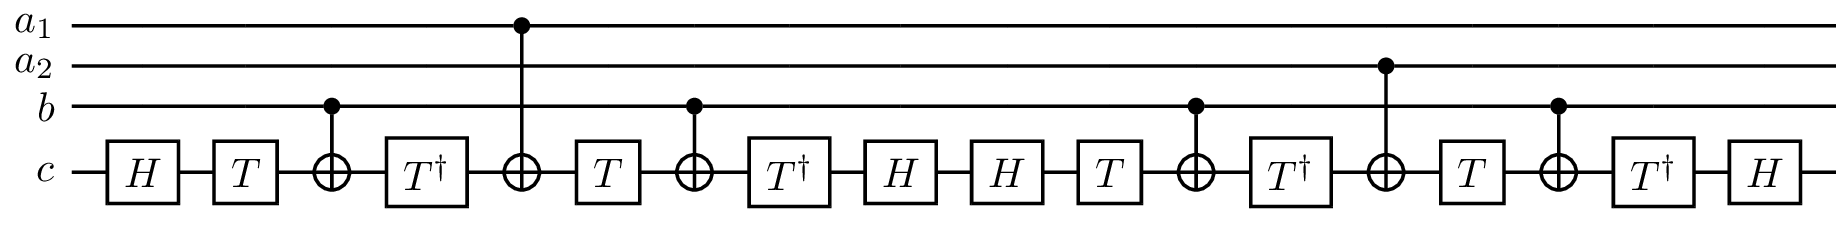

*Figure 4. When performing an $\RCCX(a_2,b,c)$ immediately after an $\RCCX(a_1,b,c)$, the middle
8 gates (including 2 CX) can be removed, as they together constitute identity.*


In [ ]:
# To facilitate gate synthesis, each qubit is in one of two logical states.
# 1. basic - normal state
# 2. rccx target - modified by u3(pi/2, pi/4, pi)
# We keep the set of qubits in state 2 below. For each operation we first make sure that the qubit
# is in the right state. If not, we transition it appropriately.
state_2_qubits = set()

star_products = [None, None, None, None]

def Initialize():
    global current_address
    global star_products
    global state_2_qubits
    current_address = 15
    state_2_qubits = set()
    star_products = [None, None, None, None]

def AssumeBasic(a):
    global state_2_qubits
    state_2_qubits.remove(a)
    
def AssumeTarget(a):
    global state_2_qubits
    state_2_qubits.add(a)

def EnsureBasic(qc, a):
    global state_2_qubits
    if a in state_2_qubits:
        state_2_qubits.remove(a)
        qc.u3(pi/2, 0, 3 * pi / 4, a)
        
def EnsureTarget(qc, a):
    global state_2_qubits
    if a not in state_2_qubits:
        state_2_qubits.add(a)
        qc.u3(pi/2, pi/4, pi, a)
        
# A version utilizing the legacy u3 gate, one gate shorter than cu3.
def cp(qc, angle, a, b):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    qc.u3(0, 0, angle / 2, a)
    qc.cx(a, b)
    qc.u3(0, 0, -angle / 2, b)
    qc.cx(a, b)
    qc.u3(0, 0, angle / 2, b)
        
# A version with lower cost than the one provided by Qiskit.
def rccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)

# Versions with negated arguments.
def rnccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(pi, pi/4, pi, c)
    qc.cx(b, c)

def rcncx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(pi, -pi/4, pi, c)
    qc.cx(a, c)
    qc.u3(pi, 0, 5*pi/4, c)
    qc.cx(b, c)

def rncncx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(pi, -pi/4, pi, c)
    qc.cx(a, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(b, c)

# Adding an x on the target qbit (after or before) an rccx is free with some clever gate synthesis.
def rccx_x(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    qc.u3(-pi/2, pi, 3 * pi/4, c)
    AssumeBasic(c)
    
def x_rccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureBasic(qc, c)
    qc.u3(-pi/2, pi/4, 0, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    AssumeTarget(c)
    
# Various scenarios of two consecutive rccx gates sharing some arguments. These allow some gate synthesis.
def x_rccx_x_change_a(qc, a1, a2, b, c):
    EnsureBasic(qc, a1)
    EnsureBasic(qc, a2)
    EnsureBasic(qc, b)
    EnsureBasic(qc, c)
    qc.u3(-pi/2, pi/4, 0, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a1, c)
    qc.cx(a2, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    qc.u3(-pi/2, pi, 3 * pi/4, c)
    
def rccx_change_a(qc, a1, a2, b, c):
    EnsureBasic(qc, a1)
    EnsureBasic(qc, a2)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a1, c)
    qc.cx(a2, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    
def rccx_flip_a(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(pi, pi / 4, 3 * pi / 4, c)
    qc.cx(b, c)
    qc.x(a)
    
def rcncx_flip_a(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.x(c)
    qc.u3(pi, pi / 4, 3 * pi / 4, c)
    qc.x(c)
    qc.cx(b, c)
    qc.x(a)
    
def rccx_flip_b(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.x(b)    
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(pi, 3 * pi / 4, pi / 4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)

def ccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureBasic(qc, c)
    qc.h(c)
    qc.cx(b, c)
    qc.tdg(c)
    qc.cx(a, c)
    qc.t(c)
    qc.cx(b, c)
    qc.tdg(c)
    qc.cx(a, c)
    qc.t(b)
    qc.u3(pi/2, 0, -3*pi/4, c)
    qc.cx(a, b)
    qc.t(a)
    qc.tdg(b)
    qc.cx(a, b)
    
def cx(qc, a, b):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    qc.cx(a, b)
    
def x(qc, a):
    EnsureBasic(qc, a)
    qc.x(a)

def Diffusion(qc, address, ancilla):
    qc.u3(pi/2, 0, 0, address[:3])
    rccx(qc, address[0], address[1], ancilla[0])

    # This can be optimized by gate synthesis.
    # qc.z(address[3])
    # ccx(qc, address[2], ancilla[0], address[3])

    # The hand-edited version of the above, saving two one-qubit gates.
    EnsureBasic(qc, ancilla[0])
    qc.u3(pi/2, 0, 0, address[3])
    qc.cx(ancilla[0], address[3])
    qc.tdg(address[3])
    qc.cx(address[2], address[3])
    qc.t(address[3])
    qc.cx(ancilla[0], address[3])
    qc.tdg(address[3])
    qc.cx(address[2], address[3])
    qc.t(ancilla[0])
    qc.u3(pi/2, 0, -3*pi/4, address[3])
    qc.cx(address[2], ancilla[0])
    qc.t(address[2])
    qc.tdg(ancilla[0])
    qc.cx(address[2], ancilla[0])

    rccx(qc, address[0], address[1], ancilla[0])
    qc.u3(-pi/2, 0, 0, address[:3])
    # Does not affect the final measurement - removing.
    # qc.z(address[3])

# Finally, we introduce the subcircuit A.
def ComputeExpensiveAncillae(qc, address, ancilla):
    rcncx (qc, address[0], address[1], ancilla[(current_address ^ 2) & 3])
    rncncx(qc, address[0], address[1], ancilla[(current_address ^ 3) & 3])
    
# Smarter walking along the Gray-code chain, trying to perform fewer CXs.
def FixCurrentAddress(qc, address, ancilla):
    global current_address
    
    # current_address = 15
    rccx  (qc, address[0], address[1], ancilla[(current_address ^ 0) & 3])
    rnccx (qc, address[0], address[1], ancilla[(current_address ^ 1) & 3])

    rccx(qc, address[2], address[3], ancilla[4])
    rccx(qc, ancilla[current_address & 3], ancilla[4], ancilla[7])
    
def SwitchCurrentAddress(new_address, qc, address, ancilla):
    global current_address
    if (current_address ^ new_address) & 12 == 0:
        rccx_change_a(
            qc, ancilla[current_address & 3], ancilla[new_address & 3],
            ancilla[4], ancilla[7])
    else:
        rccx(qc, ancilla[current_address & 3], ancilla[4], ancilla[7])
        if (current_address ^ new_address) & 8:
            rccx_flip_b(qc, address[2], address[3], ancilla[4])
        else:
            rccx_flip_a(qc, address[2], address[3], ancilla[4])
        rccx(qc, ancilla[new_address & 3], ancilla[4], ancilla[7])
    current_address = new_address
    
def UnfixCurrentAddress(qc, address, ancilla):
    global current_address
    rccx(qc, ancilla[current_address & 3], ancilla[4], ancilla[7])
    rccx(qc, address[2], address[3], ancilla[4])

    rccx  (qc, address[0], address[1], ancilla[(current_address ^ 0) & 3])
    rnccx (qc, address[0], address[1], ancilla[(current_address ^ 1) & 3])
    
# Smarter computation of two-star conjunctions. We remember what we computed recently and try to apply
# cheaper gates when trying to compute similar expressions.
def FixStarProducts():
    global star_products
    star_products = [None, None, None, None]

def UnfixStarProduct(product, qc, star, ancilla):
    global star_products
    if star_products[product] is None:
        return
    star_1, star_2 = star_products[product]
    x_rccx(qc, star[star_1], star[star_2], ancilla[product])
    star_products[product] = None

def UnfixStarProducts(qc, star, ancilla):
    global star_products
    for i in range(4):
        UnfixStarProduct(i, qc, star, ancilla)
            
def SwitchStarProduct(star_1, star_2, product, qc, star, ancilla):
    global star_products
    if star_products[product] is not None and star_products[product][1] == star_2:
        x_rccx_x_change_a(qc, star[star_products[product][0]], star[star_1], star[star_2], ancilla[product])
    else:
        UnfixStarProduct(product, qc, star, ancilla)
        rccx_x(qc, star[star_1], star[star_2], ancilla[product])
    star_products[product] = [star_1, star_2]
    
def CollectPerms(col_01, col_23, qc, star, ancilla):
    SwitchStarProduct(4 * 0 + col_01[0], 4 * 1 + col_01[1], 0, qc, star, ancilla)
    SwitchStarProduct(4 * 1 + col_01[0], 4 * 0 + col_01[1], 1, qc, star, ancilla)
    SwitchStarProduct(4 * 2 + col_23[0], 4 * 3 + col_23[1], 2, qc, star, ancilla)
    SwitchStarProduct(4 * 3 + col_23[0], 4 * 2 + col_23[1], 3, qc, star, ancilla)

    rccx(qc, ancilla[0], ancilla[1], ancilla[4])
    rccx_x(qc, ancilla[2], ancilla[3], ancilla[5])

    # Closest to -1 both for 1 and 2 applications.
    # x(qc, ancilla[4])
    # cp(qc, 2 * pi / 3, ancilla[4], ancilla[5])
    # x(qc, ancilla[5])
    
    # The hand-edited version of the above, saving two one-qubit gates.
    EnsureTarget(qc, ancilla[4])
    qc.u3(pi/2, pi/3, -pi/4, ancilla[4])
    AssumeBasic(ancilla[4])
    qc.cx(ancilla[4], ancilla[5])
    qc.u3(0, 0, -pi/3, ancilla[5])
    qc.cx(ancilla[4], ancilla[5])
    EnsureBasic(qc, ancilla[5])
    qc.u3(-pi/2, pi/4, pi/3, ancilla[5])
    AssumeTarget(ancilla[5])

    # Uncompute.
    rccx(qc, ancilla[2], ancilla[3], ancilla[5])
    x_rccx(qc, ancilla[0], ancilla[1], ancilla[4])

def week3_ans_func(problem_set, padding=False):
    # Set global variables to default values. Useful for multiple runs within the same notebook.
    Initialize()

    address = QuantumRegister(4, "address")
    star = QuantumRegister(16, "star")
    ancilla = QuantumRegister(8, "ancilla")
    
    c_address = ClassicalRegister(4, "result")

    qc = QuantumCircuit(address, star, ancilla, c_address)
    
    qc.h(address)

    for i in range(1):
        ComputeExpensiveAncillae(qc, address, ancilla)
        LoadQRAM(problem_set, qc, address, star, ancilla)

        FixStarProducts()
        # The chain below is selected so that the second coordinate of the first two arguments stays the
        # same 6 out of 10 times, thus enabling the use of cheaper gate variants.
        CollectPerms([1, 0], [2, 3], qc, star, ancilla[2:])
        CollectPerms([2, 0], [1, 3], qc, star, ancilla[2:])
        CollectPerms([3, 0], [2, 1], qc, star, ancilla[2:])
        CollectPerms([3, 2], [1, 0], qc, star, ancilla[2:])
        CollectPerms([3, 1], [2, 0], qc, star, ancilla[2:])
        CollectPerms([2, 1], [3, 0], qc, star, ancilla[2:])
        UnfixStarProducts(qc, star, ancilla[2:])
        
        LoadQRAM(problem_set, qc, address, star, ancilla)
        ComputeExpensiveAncillae(qc, address, ancilla)

        Diffusion(qc, address, star)

    qc.measure(address, c_address)

    qc = qc.reverse_bits()   
    return qc

## 8. Optimizing the QRAM set-up

This is the last round of optimizations I made. The idea came to me when looking at the
way QRAM is prepared for the sample data set. Observe that the last star is present in
boards 0, 1, 2, 3, 4, 5, 6, and 8. Therefore, instead of performing the 8 board-conditioned
CX calls sometime on the way of the Gray-code chain, we can do the following.

1. Perform a CX conditioned on the MSB of address being zero, anytime during the
   set-up.
2. Perform a CX in the Gray-code chain step corresponding to address 7.
3. Perform a CX in the Gray-code chain step corresponding to address 8.

This saves us 5 CX calls with no additional overhead.

I generalized this method to use the potential control bits already used during the QRAM
set-up process. More precisely, these were the cases used as possibilities additional
to just negating a star in the Gray-code chain.

1. No condition, just negate for all boards.
2. Condition of address bit $j$ being one, $j=0,\dots,3$.
3. Condition on two less significant bits of the address being $j$, $j=0,\dots,3$.
4. Condition on two more significant bits of the address being $j$, $j=0,\dots,3$.

The very last optimization that I made is the one that promotes applying a set of the
"block-controlled" operations such that two of the boards are left with no stars
to negate manually. This allowed skipping some of the Gray-code chain steps and gain a
better score.

In [ ]:
# We now can change more than one address bit at a time, hence the function needed rewriting.
def SwitchCurrentAddress(new_address, qc, address, ancilla):
    global current_address
    if (current_address ^ new_address) & 12 == 0:
        rccx_change_a(
            qc, ancilla[current_address & 3], ancilla[new_address & 3],
            ancilla[4], ancilla[7])
    else:
        rccx(qc, ancilla[current_address & 3], ancilla[4], ancilla[7])
        if (current_address ^ new_address) & 8:
            rccx_flip_b(qc, address[2], address[3], ancilla[4])
        else:
            rccx_flip_a(qc, address[2], address[3], ancilla[4])
        rccx(qc, ancilla[new_address & 3], ancilla[4], ancilla[7])
    current_address = new_address
    
def PerformFlips(flips, qc, enabler, star):
    for j in flips:
        cx(qc, enabler, star[j])

def LoadQRAM(qram_load_plan, qc, address, star, ancilla):
    global current_address

    FixCurrentAddress(qc, address, ancilla)

    flips, bit_flips, mod4_flips, div4_flips, board_to_star = qram_load_plan
    for i in flips:
        qc.x(star[i])
    for bit in range(4):
        current_state = (current_address >> bit) & 1
        if bit_flips[bit]:
            if not current_state:
                qc.x(address[bit])
            for j in bit_flips[bit]:
                cx(qc, address[bit], star[j])
            if not current_state:
                qc.x(address[bit])
    for rem in range(4):
        for j in mod4_flips[rem]:
            cx(qc, ancilla[rem], star[j])

    PerformFlips(div4_flips[current_address >> 2], qc, ancilla[4], star)
    LoadBoard(board_to_star[current_address], qc, star, ancilla[7])

    bits = set()
    for bit in GRAY_BITS:
        if bit in bits:
            bits.remove(bit)
        else:
            bits.add(bit)
        new_address = current_address
        for b in bits:
            new_address ^= 1 << b
        # If boards #7 or #15 turn out to be empty, we remove the optimization to
        # skip them, as this produces wrong results.
        if board_to_star[new_address] or (new_address in [7, 15]):
            SwitchCurrentAddress(new_address, qc, address, ancilla)
            if 2 in bits or 3 in bits:
                PerformFlips(div4_flips[current_address >> 2], qc, ancilla[4], star)
            bits = set()
            LoadBoard(board_to_star[current_address], qc, star, ancilla[7])

    UnfixCurrentAddress(qc, address, ancilla)

def PlanQRAMLoad(problem_set):
    star_to_board = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
    for i in range(16):
        for r, c in problem_set[i]:
            star_to_board[4 * int(r) + int(c)].append(i)

    flips = []
    bit_flips = [[], [], [], []]
    mod4_flips = [[], [], [], []]
    div4_flips = [[], [], [], []]

    all_boards = set(range(16))
    bit_set = []
    for bit in range(4):
        bit_set.append(set([i for i in range(16) if (i & (1 << bit)) != 0]))
    mod4_set = []
    for rem in range(4):
        mod4_set.append(set([i for i in range(16) if i % 4 == rem]))
    div4_set = []
    for rem in range(4):
        div4_set.append(set([i for i in range(16) if i // 4 == rem]))

    bestest_left = None
    bestest_mask = None
    bestest_ops = None
    for empty in itertools.combinations(range(16), 2):
        # The QRAM-loading code works incorrectly if the last board in the Gray-code
        # chain has no stars (after optimization). This could be fixed in the QRAM-loading code. However,
        # as we want to minimize code changes at this stage, it is more elegant to just skip the cases that
        # do not work.
        if 7 in empty or 15 in empty:
            continue

        all_best_left = []
        all_best_mask = []
        all_best_ops = []
        for i in range(16):
            best_left = None
            best_mask = None
            best_ops = None
            for mask in range(1, 1 << 13):
                left = set(star_to_board[i])
                ops = 0

                if mask & (1 << 0):
                    left ^= all_boards
                for bit in range(4):
                    if mask & (1 << (1 + bit)):
                        left ^= bit_set[bit]
                        ops += 1
                for rem in range(4):
                    if mask & (1 << (5 + rem)):
                        left ^= mod4_set[rem]
                        ops += 1
                for rem in range(4):
                    if mask & (1 << (9 + rem)):
                        left ^= div4_set[rem]
                        ops += 1
                if len(left & set(empty)):
                    continue
                if best_mask is None or ops + len(left) < best_ops + len(best_left):
                    best_mask = mask
                    best_left = left
                    best_ops = ops
            all_best_left.append(best_left)
            all_best_mask.append(best_mask)
            all_best_ops.append(best_ops)
        if bestest_mask is None or (
            sum(all_best_ops) + sum([len(l) for l in all_best_left]) <
            sum(bestest_ops) + sum([len(l) for l in bestest_left])):
                bestest_left = all_best_left
                bestest_mask = all_best_mask
                bestest_ops = all_best_ops
    for i in range(16):
        best_left = bestest_left[i]
        best_mask = bestest_mask[i]
        best_ops = bestest_ops[i]
        if best_mask & (1 << 0):
            flips.append(i)
        for bit in range(4):
            if best_mask & (1 << (1 + bit)):
                bit_flips[bit].append(i)
        for rem in range(4):
            if best_mask & (1 << (5 + rem)):
                mod4_flips[rem].append(i)
        for rem in range(4):
            if best_mask & (1 << (9 + rem)):
                div4_flips[rem].append(i)
        star_to_board[i] = best_left

    board_to_star = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
    for i in range(16):
        for j in star_to_board[i]:
            board_to_star[j].append(i)

    return (flips, bit_flips, mod4_flips, div4_flips, board_to_star)
            
def week3_ans_func(problem_set, padding=False):
    # Set global variables to default values. Useful for multiple runs within the same notebook.
    Initialize()

    address = QuantumRegister(4, "address")
    star = QuantumRegister(16, "star")
    ancilla = QuantumRegister(8, "ancilla")
    
    c_address = ClassicalRegister(4, "result")

    qc = QuantumCircuit(address, star, ancilla, c_address)
    
    qc.h(address)

    qram_load_plan = PlanQRAMLoad(problem_set)

    for i in range(1):
        ComputeExpensiveAncillae(qc, address, ancilla)
        LoadQRAM(qram_load_plan, qc, address, star, ancilla)

        FixStarProducts();
        CollectPerms([1, 0], [2, 3], qc, star, ancilla[2:])
        CollectPerms([2, 0], [1, 3], qc, star, ancilla[2:])
        CollectPerms([3, 0], [2, 1], qc, star, ancilla[2:])
        CollectPerms([3, 2], [1, 0], qc, star, ancilla[2:])
        CollectPerms([3, 1], [2, 0], qc, star, ancilla[2:])
        CollectPerms([2, 1], [3, 0], qc, star, ancilla[2:])
        UnfixStarProducts(qc, star, ancilla[2:])
        
        LoadQRAM(qram_load_plan, qc, address, star, ancilla)
        ComputeExpensiveAncillae(qc, address, ancilla)

        Diffusion(qc, address, star)

    qc.measure(address, c_address)

    qc = qc.reverse_bits()   
    return qc

## 9. The full final solution

Apart from everything mentioned above the code below contains two additional features:

* Score padding - used to artificially increase the score of a circuit to push it through the submission system. This was either forced (the server refused low scores) or voluntary (I did not want to motivate the competition, just to check if the submissions worked).

* Bug fixes - the organizers detected bugs in my code by running additional problem sets. The places fixed are marked with comments starting with "2020-12-08 bugfix". The fixes have been backported to the sections above without comments.

In [10]:
#### One-time setup after Kernel reset.
# Lower limit to 5000.
!pip install -I git+https://github.com/qiskit-community/IBMQuantumChallenge2020-Grader.git

problem_set = \
    [
    [['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
    [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
    [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
    [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
    [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']],
    [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
    [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
    [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
    [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']],
]

  Cloning https://github.com/qiskit-community/IBMQuantumChallenge2020-Grader.git to /tmp/pip-req-build-mnqum_lx
  Using cached numpy-1.19.4-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
Processing /home/jovyan/.cache/pip/wheels/bc/b7/b0/9099f1685d1bed7d4f5a7ee189ab41d3fb71ae44d71ac05994/qiskit-0.23.1-py3-none-any.whl
  Using cached requests-2.25.0-py2.py3-none-any.whl (61 kB)
  Using cached qiskit_aqua-0.8.1-py3-none-any.whl (2.1 MB)
  Using cached qiskit_ibmq_provider-0.11.1-py3-none-any.whl (195 kB)
  Using cached qiskit_ignis-0.5.1-py3-none-any.whl (204 kB)
  Using cached qiskit_terra-0.16.1-cp37-cp37m-manylinux2010_x86_64.whl (8.5 MB)
  Using cached qiskit_aer-0.7.1-cp37-cp37m-manylinux2010_x86_64.whl (17.5 MB)
  Using cached certifi-2020.12.5-py2.py3-none-any.whl (147 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached urllib3-1.26.2-py2.py3-none-any.whl (136 kB)
  Using cached scikit_learn-0.23.2-cp37

In [2]:
# Sent by Kifumi Numata. Original code did not work correctly with this data set.
problem_set_bugfix = [
[["0", "2"], ["1", "0"], ["1", "1"], ["1", "2"], ["2", "1"], ["3", "0"]], # +
[["0", "1"], ["0", "2"], ["1", "2"], ["1", "3"], ["2", "0"], ["3", "0"]], # +
[["0", "1"], ["0", "2"], ["1", "3"], ["2", "3"], ["3", "0"], ["3", "2"]], # +
[["0", "1"], ["1", "0"], ["1", "2"], ["2", "1"], ["3", "0"], ["3", "3"]], # +
[["0", "0"], ["1", "3"], ["2", "2"], ["2", "3"], ["3", "1"], ["3", "2"]], # -
[["0", "2"], ["0", "3"], ["1", "3"], ["2", "2"], ["3", "0"], ["3", "1"]], # +
[["0", "1"], ["0", "3"], ["1", "1"], ["2", "3"], ["3", "0"], ["3", "2"]], # +
[["0", "2"], ["0", "3"], ["1", "1"], ["2", "2"], ["3", "1"], ["3", "3"]], # +
[["0", "0"], ["1", "3"], ["2", "0"], ["2", "3"], ["3", "1"], ["3", "2"]], # +
[["0", "1"], ["1", "1"], ["1", "2"], ["1", "3"], ["2", "3"], ["3", "2"]], # +
[["0", "0"], ["0", "2"], ["1", "0"], ["2", "2"], ["2", "3"], ["3", "3"]], # +
[["0", "1"], ["0", "3"], ["1", "0"], ["1", "2"], ["3", "0"], ["3", "1"]], # +
[["0", "1"], ["0", "3"], ["1", "3"], ["2", "1"], ["2", "2"], ["3", "2"]], # +
[["0", "0"], ["0", "1"], ["1", "0"], ["1", "2"], ["2", "3"], ["3", "3"]], # +
[["0", "1"], ["0", "2"], ["1", "2"], ["2", "3"], ["3", "1"], ["3", "3"]], # +
[["0", "0"], ["0", "2"], ["2", "0"], ["2", "3"], ["3", "0"], ["3", "1"]], # +
]

In [15]:
import itertools
from math import pi
from qc_grader.util import compute_cost
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

GRAY_BITS = [0, 1, 0, 2, 0, 1, 0, 3, 0, 1, 0, 2, 0, 1, 0]

current_address = 15

# To facilitate gate synthesis, each qubit is in one of two logical states.
# 1. basic - normal state
# 2. rccx target - modified by u3(pi/2, pi/4, pi)
# We keep the set of qubits in state 2 below. For each operation we first make sure that the qubit
# is in the right state. If not, we transition it appropriately.
state_2_qubits = set()

star_products = [None, None, None, None]

def Initialize():
    global current_address
    global star_products
    global state_2_qubits
    current_address = 15
    state_2_qubits = set()
    star_products = [None, None, None, None]

def AssumeBasic(a):
    global state_2_qubits
    state_2_qubits.remove(a)
    
def AssumeTarget(a):
    global state_2_qubits
    state_2_qubits.add(a)

def EnsureBasic(qc, a):
    global state_2_qubits
    if a in state_2_qubits:
        state_2_qubits.remove(a)
        qc.u3(pi/2, 0, 3 * pi / 4, a)
        
def EnsureTarget(qc, a):
    global state_2_qubits
    if a not in state_2_qubits:
        state_2_qubits.add(a)
        qc.u3(pi/2, pi/4, pi, a)
        
# A version utilizing the legacy u3 gate, one gate shorter than cu3.
def cp(qc, angle, a, b):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    qc.u3(0, 0, angle / 2, a)
    qc.cx(a, b)
    qc.u3(0, 0, -angle / 2, b)
    qc.cx(a, b)
    qc.u3(0, 0, angle / 2, b)
        
# A version with lower cost than the one provided by Qiskit.
def rccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)

# Versions with negated arguments.
def rnccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(pi, pi/4, pi, c)
    qc.cx(b, c)

def rcncx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(pi, -pi/4, pi, c)
    qc.cx(a, c)
    qc.u3(pi, 0, 5*pi/4, c)
    qc.cx(b, c)

def rncncx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(pi, -pi/4, pi, c)
    qc.cx(a, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(b, c)

# Adding an x on the target qbit (after or before) an rccx is free with some clever gate synthesis.
def rccx_x(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    qc.u3(-pi/2, pi, 3 * pi/4, c)
    AssumeBasic(c)
    
def x_rccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureBasic(qc, c)
    qc.u3(-pi/2, pi/4, 0, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    AssumeTarget(c)
    
# Various scenarios of two consecutive rccx gates sharing some arguments. These allow some gate synthesis.
def x_rccx_x_change_a(qc, a1, a2, b, c):
    EnsureBasic(qc, a1)
    EnsureBasic(qc, a2)
    EnsureBasic(qc, b)
    EnsureBasic(qc, c)
    qc.u3(-pi/2, pi/4, 0, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a1, c)
    qc.cx(a2, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    qc.u3(-pi/2, pi, 3 * pi/4, c)
    
def rccx_change_a(qc, a1, a2, b, c):
    EnsureBasic(qc, a1)
    EnsureBasic(qc, a2)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a1, c)
    qc.cx(a2, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)
    
def rccx_flip_a(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.u3(pi, pi / 4, 3 * pi / 4, c)
    qc.cx(b, c)
    qc.x(a)
    
def rcncx_flip_a(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.x(c)
    qc.u3(pi, pi / 4, 3 * pi / 4, c)
    qc.x(c)
    qc.cx(b, c)
    qc.x(a)
    
def rccx_flip_b(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureTarget(qc, c)
    qc.cx(b, c)
    qc.x(b)    
    qc.u3(0, 0, -pi/4, c)
    qc.cx(a, c)
    qc.u3(pi, 3 * pi / 4, pi / 4, c)
    qc.cx(a, c)
    qc.u3(0, 0, pi/4, c)
    qc.cx(b, c)

def ccx(qc, a, b, c):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    EnsureBasic(qc, c)
    qc.h(c)
    qc.cx(b, c)
    qc.tdg(c)
    qc.cx(a, c)
    qc.t(c)
    qc.cx(b, c)
    qc.tdg(c)
    qc.cx(a, c)
    qc.t(b)
    qc.u3(pi/2, 0, -3*pi/4, c)
    qc.cx(a, b)
    qc.t(a)
    qc.tdg(b)
    qc.cx(a, b)
    
def cx(qc, a, b):
    EnsureBasic(qc, a)
    EnsureBasic(qc, b)
    qc.cx(a, b)
    
def x(qc, a):
    EnsureBasic(qc, a)
    qc.x(a)

### Real code starts below. Because of the logical-state trick, no qubit that is a recent rcxx target
### should be directly given to any qc.[gate] call.

def Diffusion(qc, address, ancilla):
    qc.u3(pi/2, 0, 0, address[:3])
    rccx(qc, address[0], address[1], ancilla[0])

    # This can be optimized by gate synthesis.
    # qc.z(address[3])
    # ccx(qc, address[2], ancilla[0], address[3])

    # The hand-edited version of the above, saving two one-qubit gates.
    EnsureBasic(qc, ancilla[0])
    qc.u3(pi/2, 0, 0, address[3])
    qc.cx(ancilla[0], address[3])
    qc.tdg(address[3])
    qc.cx(address[2], address[3])
    qc.t(address[3])
    qc.cx(ancilla[0], address[3])
    qc.tdg(address[3])
    qc.cx(address[2], address[3])
    qc.t(ancilla[0])
    qc.u3(pi/2, 0, -3*pi/4, address[3])
    qc.cx(address[2], ancilla[0])
    qc.t(address[2])
    qc.tdg(ancilla[0])
    qc.cx(address[2], ancilla[0])

    rccx(qc, address[0], address[1], ancilla[0])
    qc.u3(-pi/2, 0, 0, address[:3])
    # Does not affect the final measurement - removing.
    # qc.z(address[3])

### QRAM load/unload section starts here.
    
def ComputeExpensiveAncillae(qc, address, ancilla):
    rcncx (qc, address[0], address[1], ancilla[(current_address ^ 2) & 3])
    rncncx(qc, address[0], address[1], ancilla[(current_address ^ 3) & 3])
    
def FixCurrentAddress(qc, address, ancilla):
    global current_address
    
    # current_address = 15
    rccx  (qc, address[0], address[1], ancilla[(current_address ^ 0) & 3])
    rnccx (qc, address[0], address[1], ancilla[(current_address ^ 1) & 3])

    rccx(qc, address[2], address[3], ancilla[4])
    rccx(qc, ancilla[current_address & 3], ancilla[4], ancilla[7])
    
def SwitchCurrentAddress(new_address, qc, address, ancilla):
    global current_address
    if (current_address ^ new_address) & 12 == 0:
        rccx_change_a(
            qc, ancilla[current_address & 3], ancilla[new_address & 3],
            ancilla[4], ancilla[7])
    else:
        rccx(qc, ancilla[current_address & 3], ancilla[4], ancilla[7])
        if (current_address ^ new_address) & 8:
            rccx_flip_b(qc, address[2], address[3], ancilla[4])
        else:
            rccx_flip_a(qc, address[2], address[3], ancilla[4])
        rccx(qc, ancilla[new_address & 3], ancilla[4], ancilla[7])
    current_address = new_address
    
def UnfixCurrentAddress(qc, address, ancilla):
    global current_address
    rccx(qc, ancilla[current_address & 3], ancilla[4], ancilla[7])
    rccx(qc, address[2], address[3], ancilla[4])

    rccx  (qc, address[0], address[1], ancilla[(current_address ^ 0) & 3])
    rnccx (qc, address[0], address[1], ancilla[(current_address ^ 1) & 3])
    
def LoadBoard(board, qc, star, enabler):
    for i in board:
        cx(qc, enabler, star[i])

def PerformFlips(flips, qc, enabler, star):
    for j in flips:
        cx(qc, enabler, star[j])

def LoadQRAM(qram_load_plan, qc, address, star, ancilla):
    global current_address

    FixCurrentAddress(qc, address, ancilla)

    flips, bit_flips, mod4_flips, div4_flips, board_to_star = qram_load_plan
    for i in flips:
        qc.x(star[i])
    for bit in range(4):
        current_state = (current_address >> bit) & 1
        if bit_flips[bit]:
            if not current_state:
                qc.x(address[bit])
            for j in bit_flips[bit]:
                cx(qc, address[bit], star[j])
            if not current_state:
                qc.x(address[bit])
    for rem in range(4):
        for j in mod4_flips[rem]:
            cx(qc, ancilla[rem], star[j])

    PerformFlips(div4_flips[current_address >> 2], qc, ancilla[4], star)
    LoadBoard(board_to_star[current_address], qc, star, ancilla[7])

    bits = set()
    for bit in GRAY_BITS:
        if bit in bits:
            bits.remove(bit)
        else:
            bits.add(bit)
        new_address = current_address
        for b in bits:
            new_address ^= 1 << b
        # 2020-12-08 bugfix. If boards #7 or #15 turn out to be empty, we remove the optimization to
        # skip them, as this produces wrong results.
        if board_to_star[new_address] or (new_address in [7, 15]):
            SwitchCurrentAddress(new_address, qc, address, ancilla)
            if 2 in bits or 3 in bits:
                PerformFlips(div4_flips[current_address >> 2], qc, ancilla[4], star)
            bits = set()
            LoadBoard(board_to_star[current_address], qc, star, ancilla[7])

    UnfixCurrentAddress(qc, address, ancilla)

def PlanQRAMLoad(problem_set):
    star_to_board = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
    for i in range(16):
        for r, c in problem_set[i]:
            star_to_board[4 * int(r) + int(c)].append(i)
    # print("raw", star_to_board)

    flips = []
    bit_flips = [[], [], [], []]
    mod4_flips = [[], [], [], []]
    div4_flips = [[], [], [], []]

    all_boards = set(range(16))
    bit_set = []
    for bit in range(4):
        bit_set.append(set([i for i in range(16) if (i & (1 << bit)) != 0]))
    mod4_set = []
    for rem in range(4):
        mod4_set.append(set([i for i in range(16) if i % 4 == rem]))
    div4_set = []
    for rem in range(4):
        div4_set.append(set([i for i in range(16) if i // 4 == rem]))

    bestest_left = None
    bestest_mask = None
    bestest_ops = None
    for empty in itertools.combinations(range(16), 2):
        # 2020-12-08 bugfix. The QRAM-loading code works incorrectly if the last board in the Gray-code
        # chain has no stars (after optimization). This could be fixed in the QRAM-loading code. However,
        # as we want to minimize code changes at this stage, it is more elegant to just skip the cases that
        # do not work.
        if 7 in empty or 15 in empty:
            continue

        all_best_left = []
        all_best_mask = []
        all_best_ops = []
        for i in range(16):
            best_left = None
            best_mask = None
            best_ops = None
            for mask in range(1, 1 << 13):
                left = set(star_to_board[i])
                ops = 0

                if mask & (1 << 0):
                    left ^= all_boards
                for bit in range(4):
                    if mask & (1 << (1 + bit)):
                        left ^= bit_set[bit]
                        ops += 1
                for rem in range(4):
                    if mask & (1 << (5 + rem)):
                        left ^= mod4_set[rem]
                        ops += 1
                for rem in range(4):
                    if mask & (1 << (9 + rem)):
                        left ^= div4_set[rem]
                        ops += 1
                if len(left & set(empty)):
                    continue
                if best_mask is None or ops + len(left) < best_ops + len(best_left):
                    best_mask = mask
                    best_left = left
                    best_ops = ops
            all_best_left.append(best_left)
            all_best_mask.append(best_mask)
            all_best_ops.append(best_ops)
        if bestest_mask is None or (
            sum(all_best_ops) + sum([len(l) for l in all_best_left]) <
            sum(bestest_ops) + sum([len(l) for l in bestest_left])):
                bestest_left = all_best_left
                bestest_mask = all_best_mask
                bestest_ops = all_best_ops
    for i in range(16):
        best_left = bestest_left[i]
        best_mask = bestest_mask[i]
        best_ops = bestest_ops[i]
        # print(i, len(star_to_board[i]), best_ops, len(best_left))
        if best_mask & (1 << 0):
            flips.append(i)
        for bit in range(4):
            if best_mask & (1 << (1 + bit)):
                bit_flips[bit].append(i)
        for rem in range(4):
            if best_mask & (1 << (5 + rem)):
                mod4_flips[rem].append(i)
        for rem in range(4):
            if best_mask & (1 << (9 + rem)):
                div4_flips[rem].append(i)
        star_to_board[i] = best_left

    board_to_star = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
    for i in range(16):
        for j in star_to_board[i]:
            board_to_star[j].append(i)

    # print("flips", flips)
    # print("bit_flips", bit_flips)
    # print("mod4_flips", mod4_flips)
    # print("div4_flips", div4_flips)
    # print("star_to_board", star_to_board)
    # print("board_to_star", board_to_star)
    return (flips, bit_flips, mod4_flips, div4_flips, board_to_star)
            
### QRAM section end.

### Phase oracle section starts here.

def FixStarProducts():
    global star_products
    star_products = [None, None, None, None]

def UnfixStarProduct(product, qc, star, ancilla):
    global star_products
    if star_products[product] is None:
        return
    star_1, star_2 = star_products[product]
    x_rccx(qc, star[star_1], star[star_2], ancilla[product])
    star_products[product] = None

def UnfixStarProducts(qc, star, ancilla):
    global star_products
    for i in range(4):
        UnfixStarProduct(i, qc, star, ancilla)
            
def SwitchStarProduct(star_1, star_2, product, qc, star, ancilla):
    global star_products
    if star_products[product] is not None and star_products[product][1] == star_2:
        x_rccx_x_change_a(qc, star[star_products[product][0]], star[star_1], star[star_2], ancilla[product])
    else:
        UnfixStarProduct(product, qc, star, ancilla)
        rccx_x(qc, star[star_1], star[star_2], ancilla[product])
    star_products[product] = [star_1, star_2]
    
def CollectPerms(col_01, col_23, qc, star, ancilla):
    SwitchStarProduct(4 * 0 + col_01[0], 4 * 1 + col_01[1], 0, qc, star, ancilla)
    SwitchStarProduct(4 * 1 + col_01[0], 4 * 0 + col_01[1], 1, qc, star, ancilla)
    SwitchStarProduct(4 * 2 + col_23[0], 4 * 3 + col_23[1], 2, qc, star, ancilla)
    SwitchStarProduct(4 * 3 + col_23[0], 4 * 2 + col_23[1], 3, qc, star, ancilla)

    rccx(qc, ancilla[0], ancilla[1], ancilla[4])
    rccx_x(qc, ancilla[2], ancilla[3], ancilla[5])

    # Closest to -1 both for 1 and 2 applications.
    # x(qc, ancilla[4])
    # cp(qc, 2 * pi / 3, ancilla[4], ancilla[5])
    # x(qc, ancilla[5])
    
    # The hand-edited version of the above, saving two one-qubit gates.
    EnsureTarget(qc, ancilla[4])
    qc.u3(pi/2, pi/3, -pi/4, ancilla[4])
    AssumeBasic(ancilla[4])
    qc.cx(ancilla[4], ancilla[5])
    # 2020-12-08 bugfix. Typo when copying from a sheet of paper. The (wrong) angle used to be -pi/2.
    qc.u3(0, 0, -pi/3, ancilla[5])
    qc.cx(ancilla[4], ancilla[5])
    EnsureBasic(qc, ancilla[5])
    qc.u3(-pi/2, pi/4, pi/3, ancilla[5])
    AssumeTarget(ancilla[5])

    # Uncompute.
    rccx(qc, ancilla[2], ancilla[3], ancilla[5])
    x_rccx(qc, ancilla[0], ancilla[1], ancilla[4])
    
### Phase oracle section end.
    
def week3_ans_func(problem_set, padding=False):
    # Set global variables to default values. Useful for multiple runs within the same notebook.
    Initialize()

    address = QuantumRegister(4, "address")
    star = QuantumRegister(16, "star")
    ancilla = QuantumRegister(8, "ancilla")
    
    c_address = ClassicalRegister(4, "result")

    qc = QuantumCircuit(address, star, ancilla, c_address)
    
    qc.h(address)

    qram_load_plan = PlanQRAMLoad(problem_set)

    for i in range(1):
        ComputeExpensiveAncillae(qc, address, ancilla)
        LoadQRAM(qram_load_plan, qc, address, star, ancilla)

        FixStarProducts();
        CollectPerms([1, 0], [2, 3], qc, star, ancilla[2:])
        CollectPerms([2, 0], [1, 3], qc, star, ancilla[2:])
        CollectPerms([3, 0], [2, 1], qc, star, ancilla[2:])
        CollectPerms([3, 2], [1, 0], qc, star, ancilla[2:])
        CollectPerms([3, 1], [2, 0], qc, star, ancilla[2:])
        CollectPerms([2, 1], [3, 0], qc, star, ancilla[2:])
        UnfixStarProducts(qc, star, ancilla[2:])
        
        LoadQRAM(qram_load_plan, qc, address, star, ancilla)
        ComputeExpensiveAncillae(qc, address, ancilla)

        Diffusion(qc, address, star)

    for i in range(4):
        if (current_address & (1 << i)) == 0:
            qc.x(address[i])

    qc.measure(address, c_address)

    real_cost = compute_cost(qc)
    print(real_cost)
    if padding:
        # Padding.
        TARGET_SCORE = 7093
        for i in range(real_cost, TARGET_SCORE):
            qc.x(star[0])

    qc = qc.reverse_bits()   
    return qc

In [16]:
# Submission code
from qc_grader import grade_ex3, prepare_ex3, submit_ex3

# Execute your circuit with following prepare_ex3() function.
# The prepare_ex3() function works like the execute() function with only QuantumCircuit as an argument.
job = prepare_ex3(week3_ans_func)

result = job.result()
counts = result.get_counts()
original_problem_set_counts = counts[0]

original_problem_set_counts
counts
# The bit string with the highest number of observations is treated as the solution.

Running week3_ans_func...
Computing cost...
6065
Computing cost...
Computing cost...
6045
Starting experiments. Please wait...
You may monitor the job (id: 5fd281e27d5d760013b9f2a1) status and proceed to grading when it successfully completes.


[{'0000': 41,
  '0001': 48,
  '0010': 43,
  '0011': 36,
  '0100': 51,
  '0101': 370,
  '0110': 40,
  '0111': 40,
  '1000': 52,
  '1001': 36,
  '1010': 40,
  '1011': 43,
  '1100': 35,
  '1101': 36,
  '1110': 46,
  '1111': 43},
 {'0000': 55,
  '0001': 39,
  '0010': 43,
  '0011': 38,
  '0100': 37,
  '0101': 28,
  '0110': 43,
  '0111': 36,
  '1000': 32,
  '1001': 57,
  '1010': 43,
  '1011': 379,
  '1100': 50,
  '1101': 50,
  '1110': 31,
  '1111': 39}]

In [17]:
# Check your answer by executing following code.
# The quantum cost of the QuantumCircuit is obtained as the score. The lower the cost, the better.
grade_ex3(job)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 6065.
The lower your score the better!
Feel free to submit your answer.


In [18]:
# Submit your results by executing following code. You can submit as many times as you like during the period. 
submit_ex3(job)

Submitting your answer. Please wait...
Failed: Error wrong data received.


## 10. Auxiliary code snippets

The snippet is used to run the circuit locally, as it is significantly faster than queueing a solution via the submission code.


In [19]:
from qiskit import QuantumCircuit, execute, Aer
from qc_grader.util import compute_cost

backend_sim = Aer.get_backend('qasm_simulator')
qct = week3_ans_func(problem_set)
print(qct.count_ops())
cost = compute_cost(qct)
print(cost)
job_sim = execute(qct, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
countz = result_sim.get_counts(qct)
print(countz)

Computing cost...
6065
OrderedDict([('cx', 562), ('u3', 419), ('x', 16), ('h', 4), ('measure', 4), ('tdg', 3), ('t', 3)])
Computing cost...
6065
{'0000': 38, '0001': 47, '0010': 37, '0011': 54, '0100': 50, '0101': 401, '0110': 45, '0111': 43, '1000': 38, '1001': 39, '1010': 33, '1011': 37, '1100': 44, '1101': 34, '1110': 42, '1111': 42}
